In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NTK Beamforming


In [7]:
import numpy as np
import h5py
f = h5py.File('/opt/projects/generally_intelligent/standalone/llms/1_48_tofu_milk_doppler_10_100.mat','r')
# # data = f.get('data/variable1')
# # data = np.array(data) # For converting to a NumPy array

# import numpy as np
# import scipy.io
# mat = scipy.io.loadmat('1_48_tofu_purple_straw_single_angle.mat')
raw_rf_data = np.array(f[f['RcvData'][0,0]]).transpose((2,1,0))

600

In [11]:
aperture_permutation = [22,21,20,40,23,41,45,42,44,43,46,17,16,47,12,19,18,13,14,15,48,49,53,50,52,51,8,54,55,10,11,4,5,6,7,9,3,2,1,0,39,38,37,36,32,33,34,35]
len(aperture_permutation)

48

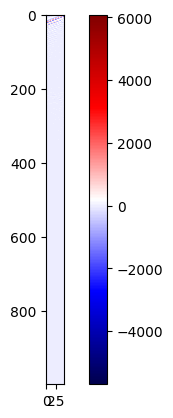

In [172]:
import matplotlib.pyplot as plt
plt.imshow(raw_rf_data[2048*0:2048*0+1000,aperture_permutation,0], cmap="seismic")
plt.colorbar()
plt.show()

In [176]:
from imaging.demodulate import demodulate_rf_to_iq

transducer_frequency = 2.5e6 # default verasonics is 2.5MHz
freq_sampling = 4 * transducer_frequency
iq_signals, freq_carrier = demodulate_rf_to_iq(
    raw_rf_data[2048*0+4200:2048*0+5200,aperture_permutation,0], freq_sampling, freq_carrier=transducer_frequency
)

freq_carrier

2500000.0

In [177]:
N = 220
Nz = 200
dx0 = 2.95e-4

nelements = 48

# Generate 1D arrays for x and z
x = np.linspace(-(N // 2) * dx0, (N // 2) * dx0, N)
z = np.linspace(0, Nz * dx0, Nz)

# Create 2D meshgrid for x and z
X, Z = np.meshgrid(x, z)

N, Nz, dx0

(220, 200, 0.000295)

In [178]:
from imaging.beamform import beamform_delay_and_sum

beamformed_signal = beamform_delay_and_sum(
    iq_signals,
    X,
    Z,
    freq_sampling,
    freq_carrier,
    pitch=dx0,
    tx_delays=np.zeros(nelements),
)

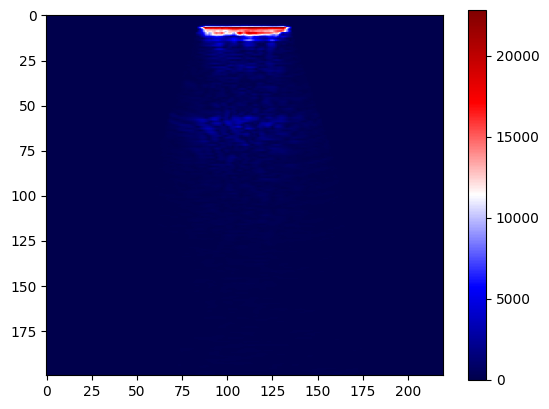

In [179]:
plt.imshow(np.abs(beamformed_signal), cmap="seismic")
plt.colorbar()
plt.show()

In [180]:
all_beamformed_signals = []
for i in range(600):
    iq_signals, freq_carrier = demodulate_rf_to_iq(
        raw_rf_data[2048*0+4200:2048*0+5200,aperture_permutation,i], freq_sampling, freq_carrier=transducer_frequency
    )
    beamformed_signal = beamform_delay_and_sum(
        iq_signals,
        X,
        Z,
        freq_sampling,
        freq_carrier,
        pitch=dx0,
        tx_delays=np.zeros(nelements),
    )
    all_beamformed_signals.append(beamformed_signal)
    if i % 50 == 0:
        print(f"done with {i}")
all_beamformed_signals = np.array(all_beamformed_signals)

all_beamformed_signals.shape

done with 0
done with 50
done with 100
done with 150
done with 200
done with 250
done with 300
done with 350
done with 400
done with 450
done with 500
done with 550


(600, 200, 220)

## Bad Doppler Data

In [181]:
def power_doppler(start_frame, end_frame):
    # start and end frames are indices. frame rate is around 60 Hz
    fft_data = np.fft.fft(all_beamformed_signals[start_frame:end_frame], axis=0)
    freqs = np.fft.fftfreq(end_frame - start_frame, 1/60)
    high_pass = fft_data[abs(freqs)> 2 * transducer_frequency * 4e-3 / 1540] # 1540 m/s is speed of sound, 4e-3 m/s is tissue slow movements
    return np.sum(np.abs(high_pass)**2,axis=0)

power = power_doppler(12, 24)
power.shape

(200, 220)

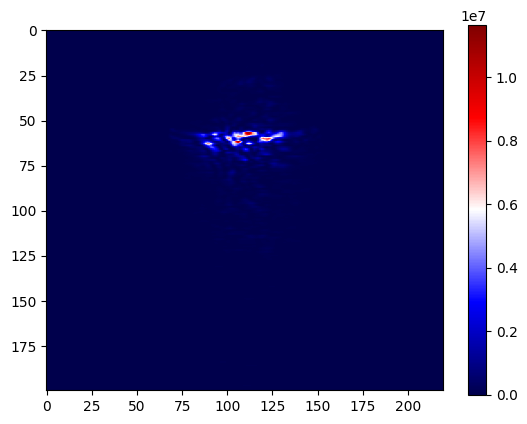

In [182]:
plt.imshow(power[:,:], cmap="seismic")
plt.colorbar()
plt.show()

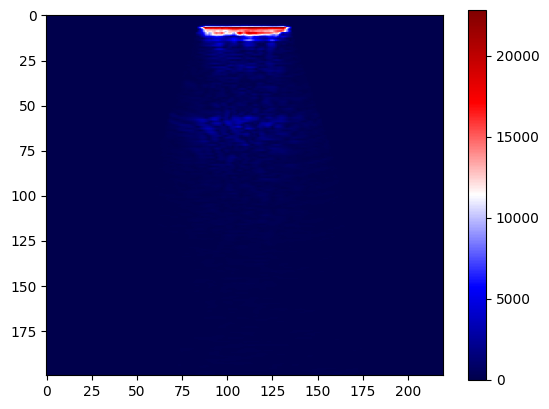

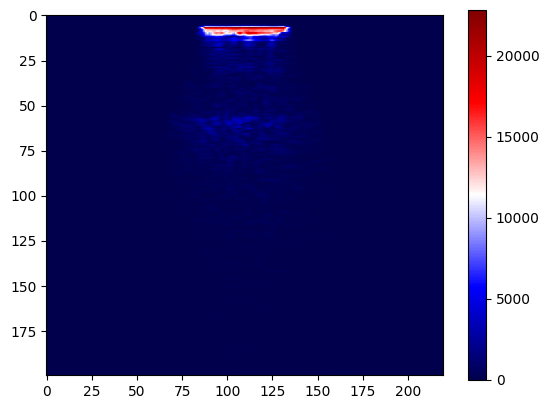

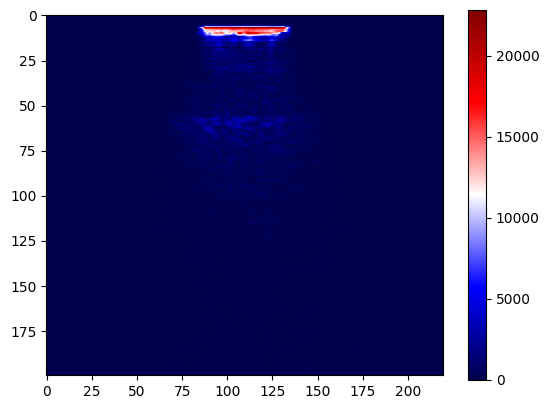

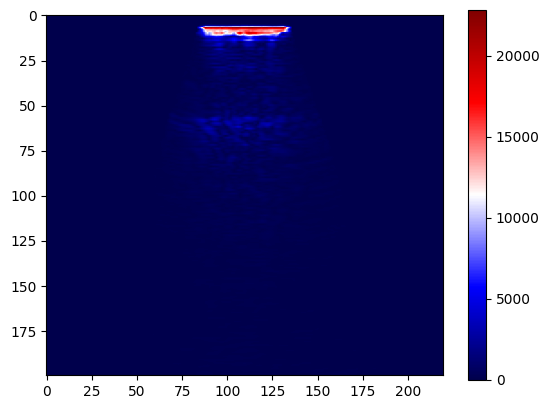

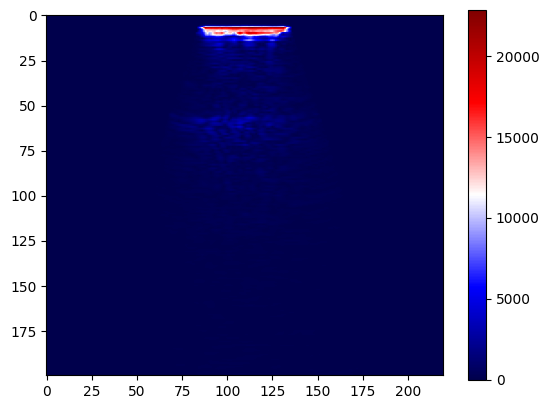

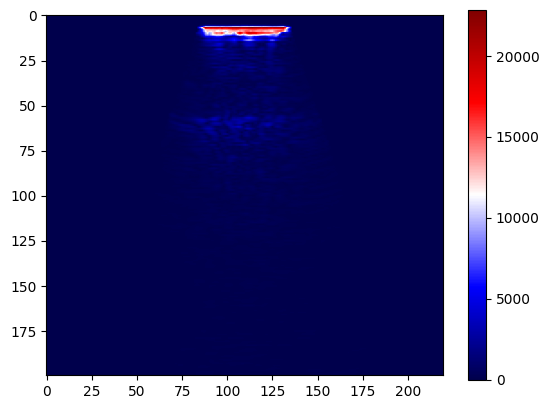

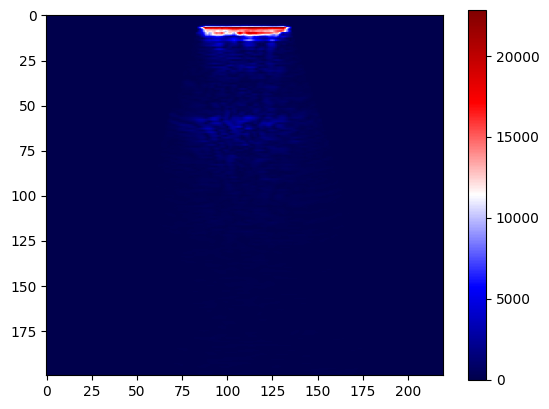

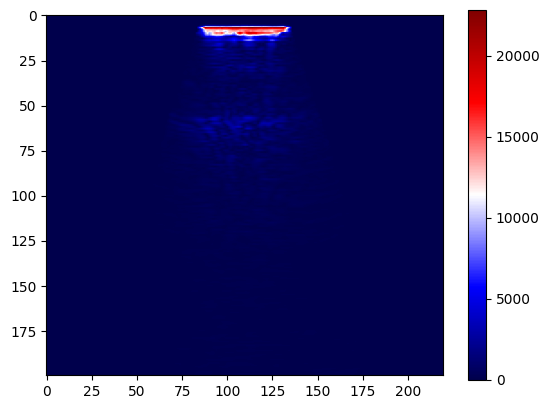

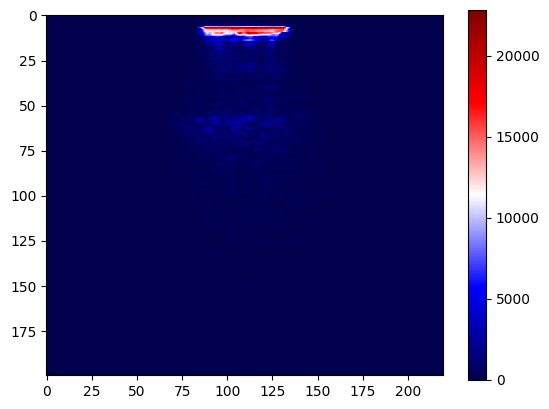

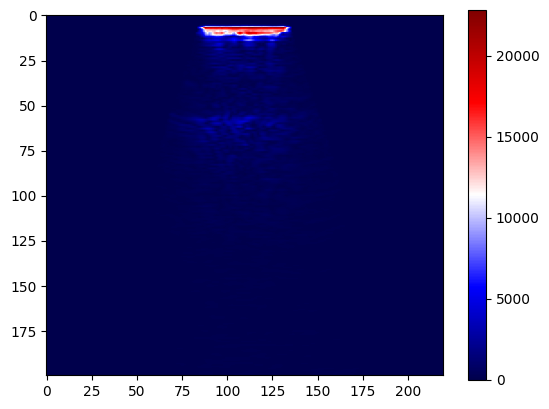

In [183]:
for i in range(10):
    plt.imshow((np.abs(all_beamformed_signals[50*i])), cmap="seismic")
    plt.colorbar()
    plt.show()

## Better Doppler Data

In [186]:
# gdown 1oeQt9YSlFsACUqtyK99VkUpfTz2v3ldh
# import numpy as np
# import h5py
# f = h5py.File('/opt/projects/generally_intelligent/standalone/llms/1_48_tofu_milk_doppler_10_100.mat','r')
# # # data = f.get('data/variable1')
# # # data = np.array(data) # For converting to a NumPy array

import numpy as np
import scipy.io
mat = scipy.io.loadmat('08_17_doppler_10mms_300us.mat')
mat.keys()

/opt/venv/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AxesUnit', 'BG', 'Control', 'DisplayData', 'DwHeight', 'DwWidth', 'Event', 'ID', 'IData', 'ImgData', 'ImgDataP', 'LEsys', 'LogData', 'Media', 'MinMaxVal', 'P', 'PB', 'PData', 'Presence', 'Process', 'QData', 'RcvData', 'RcvProfile', 'Receive', 'Recon', 'ReconInfo', 'RequiredStructs', 'Resource', 'Result', 'SG', 'ScrnSize', 'SeqControl', 'TGC', 'TPC', 'TW', 'TX', 'TXEventCheckh', 'TX_Limits', 'Trans', 'UI', 'UIPos', 'UTA', 'UTAtype', 'VDAS', 'VDASupdates', 'VSX_Control', 'action', 'ans', 'apernum', 'apod', 'arbwaveTxLicenseIsValid', 'autoScriptTest', 'axisname', 'computeHVMux', 'None', 'displayWindowTitle', 'errMsg', 'extendedTxLicenseIsValid', 'fid', 'frameRateFactor', 'freeze', 'freqRngRqd', 'gpuDirectLicenseIsValid', 'gpuToolkitLicenseIsValid', 'hardwareLicenseIsValid', 'hv2GUIprofile', 'hvDefault', 'hvMax', 'i', 'initialized', 'isHwInFaultState', 'isUsingOldVSXGUIcreation', 'j', 'k', 'maxADRate', 'maxAcqLength', 'minADRate', 'mi

In [191]:
raw_doppler_data = mat['RcvData'][0,0]

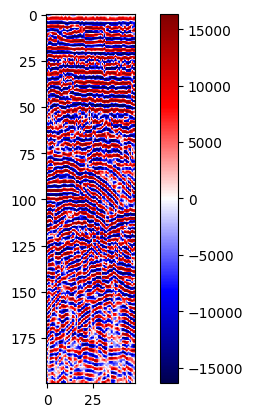

In [233]:
import matplotlib.pyplot as plt
plt.imshow(raw_doppler_data[:200,aperture_permutation,10], cmap="seismic")
plt.colorbar()
plt.show()

In [200]:
all_beamformed_doppler_signals = []
for i in range(8000):
    iq_signals, freq_carrier = demodulate_rf_to_iq(
        raw_doppler_data[:800,aperture_permutation,i], freq_sampling, freq_carrier=transducer_frequency
    )
    beamformed_signal = beamform_delay_and_sum(
        iq_signals,
        X,
        Z,
        freq_sampling,
        freq_carrier,
        pitch=dx0,
        tx_delays=np.zeros(nelements),
    )
    all_beamformed_doppler_signals.append(beamformed_signal)
    if i % 500 == 0:
        print(f"done with {i}")
all_beamformed_doppler_signals = np.array(all_beamformed_doppler_signals)

all_beamformed_doppler_signals.shape

done with 0
done with 500
done with 1000
done with 1500
done with 2000
done with 2500
done with 3000
done with 3500
done with 4000
done with 4500
done with 5000
done with 5500
done with 6000
done with 6500
done with 7000
done with 7500


(8000, 200, 220)

In [204]:
np.save("/mnt/shared/doppler.npy", all_beamformed_doppler_signals)

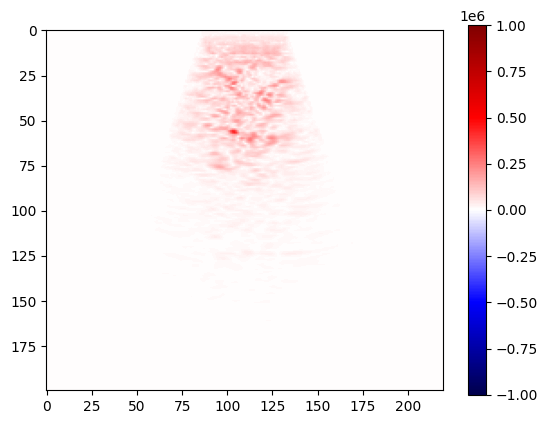

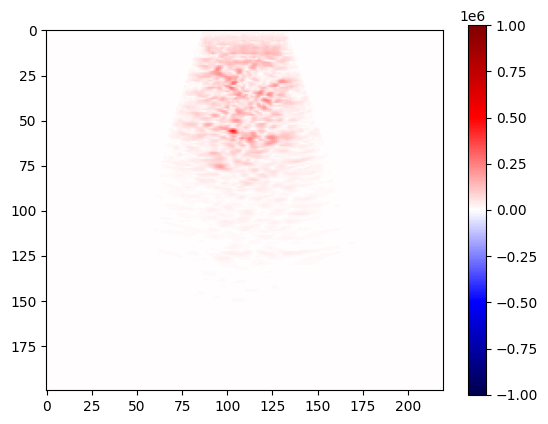

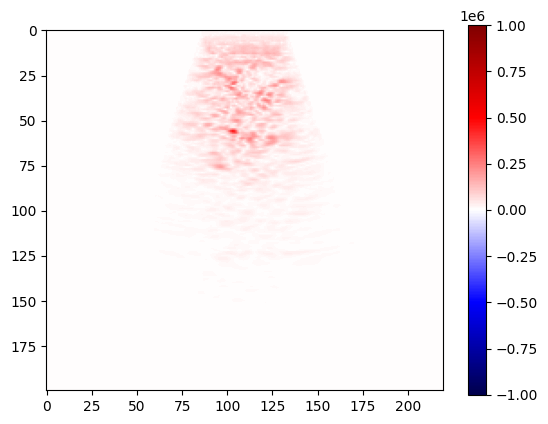

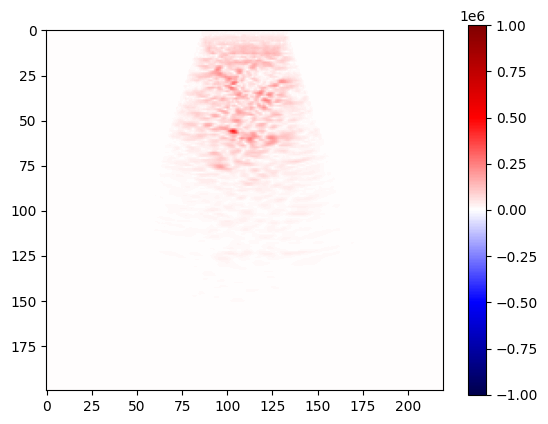

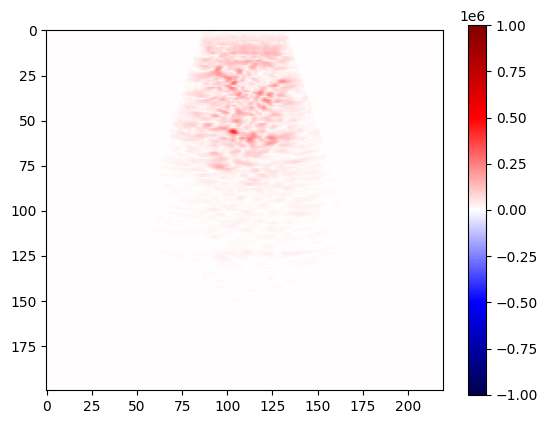

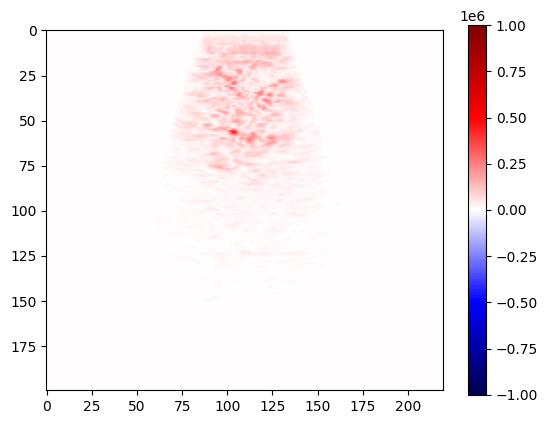

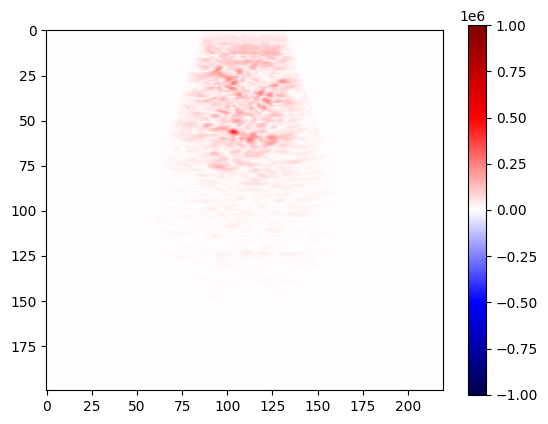

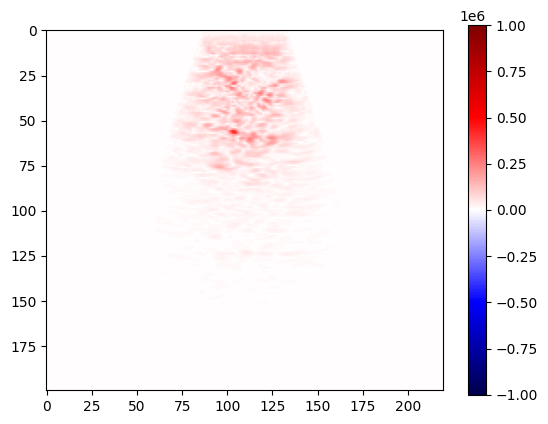

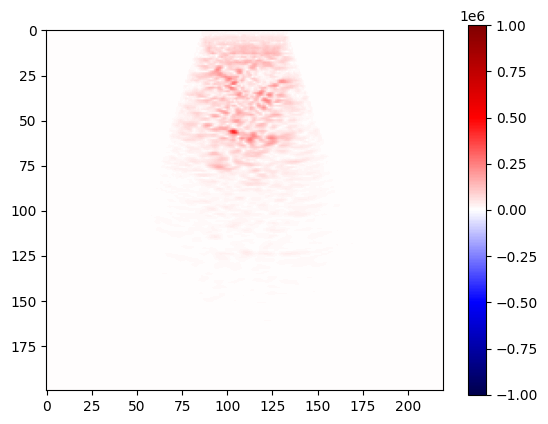

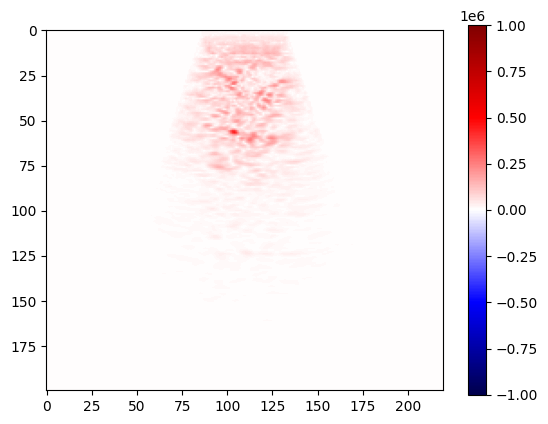

In [209]:
for i in range(10):
    plt.imshow((np.abs(all_beamformed_doppler_signals[800*i])), cmap="seismic", vmin=-1e6, vmax=1e6)
    plt.colorbar()
    plt.show()

In [243]:
def power_doppler_2(start_frame, end_frame):
    # start and end frames are indices. frame rate is around 3300 Hz
    fft_data = np.fft.fft(all_beamformed_doppler_signals[start_frame:end_frame], axis=0)
    freqs = np.fft.fftfreq(end_frame - start_frame, 1/3300)
    high_pass = fft_data[(abs(freqs)> 2 * transducer_frequency * 4e-3 / 1540)] # 1540 m/s is speed of sound, 4e-3 m/s is tissue slow movements
    return np.sum(np.abs(high_pass)**2,axis=0)

power = power_doppler_2(0, 660)
power.shape

(200, 220)

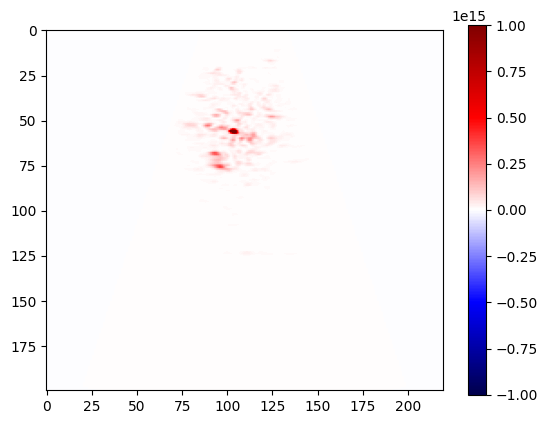

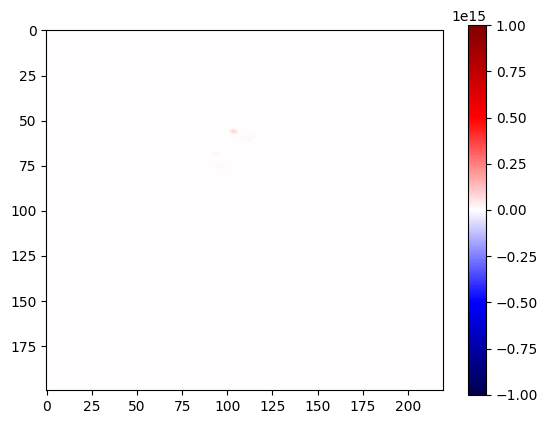

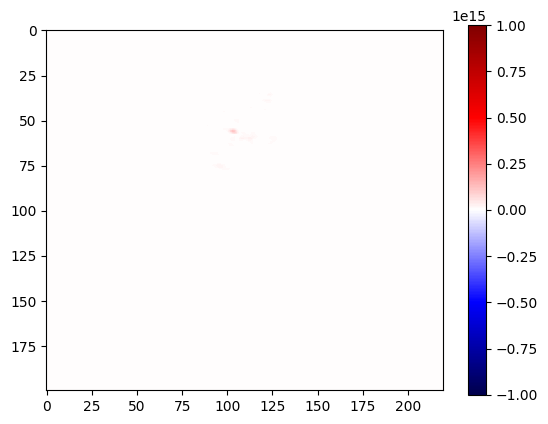

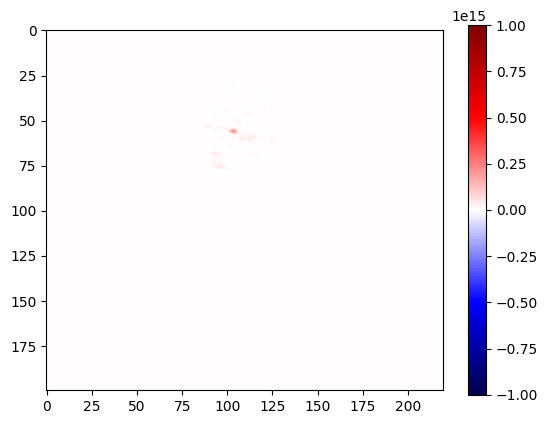

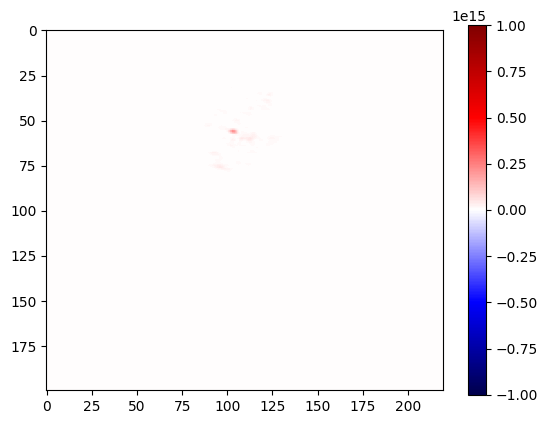

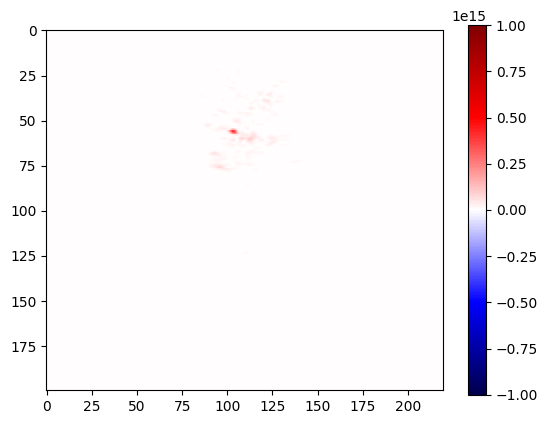

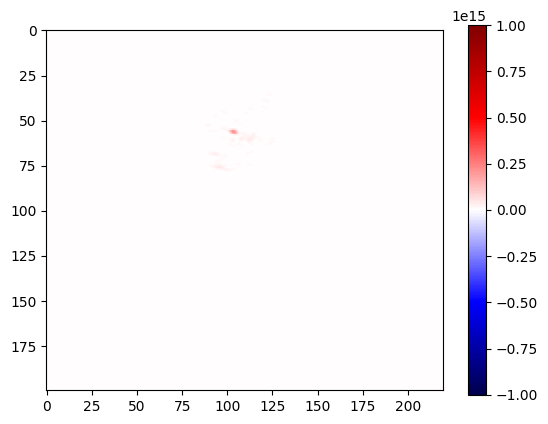

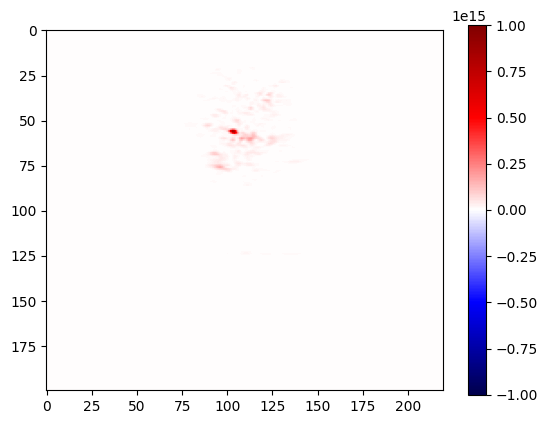

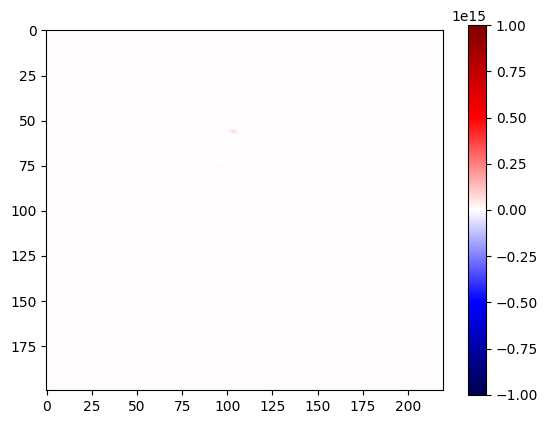

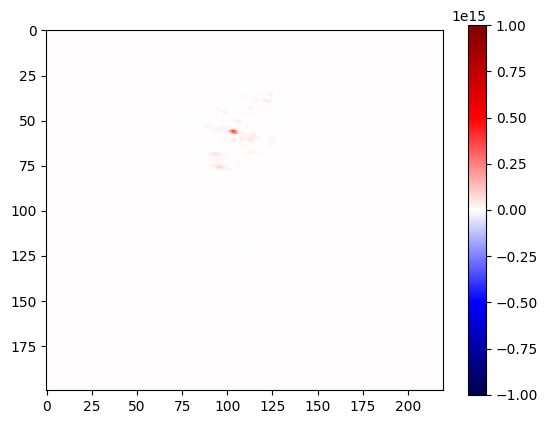

In [244]:
for t in range(10):
    power = power_doppler_2(660*t, 660*(t+1))
    plt.imshow(power[:,:], cmap="seismic", vmin=-1e15, vmax=1e15)
    plt.colorbar()
    plt.show()